\begin{center} 
Chun-Yuan (Scott) Chiu 
\end{center}
\begin{center} 
chunyuac@andrew.cmu.edu 
\end{center}

# 1. {-}

For completeness we list Form 1 here: 

\begin{align*}
&\text{Maximize } M\\
&\text{Subject to } \sum_{i=1}^n\epsilon_i \le C, \epsilon_i\ge 0, y_i(x_i^T\beta+\beta_0) \ge M(1-\epsilon_i), \lVert\beta\rVert_2=1. \qquad \text{(Form 1)}
\end{align*}

## (a) {-}

Assume $b$ is positive. 
Replacing $\beta$ by $b\beta$ and $\beta_0$ by $b\beta_0$ the inequality 

\begin{align*}
y_i(x_i^T\beta + \beta_0) \ge M(1-\epsilon_i)\lVert\beta\rVert_2, 
\end{align*}

we obtain 

\begin{align*}
& y_i(x_i^T(b\beta) + b\beta_0) \ge M(1-\epsilon_i)\lVert b\beta\rVert_2 \\
\iff& by_i(x_i^T\beta + \beta_0) \ge b M(1-\epsilon_i)\lVert \beta\rVert_2 \\
\iff& y_i(x_i^T\beta + \beta_0) \ge M(1-\epsilon_i)\lVert \beta\rVert_2, 
\end{align*}

which is the original inequality. Thus scaling the coefficients of the equation of the decision boundary does not do anything to the inequality. 


Given this observation we choose $\lVert\beta\rVert_2$ to be $1/\sqrt{M}$, rewriting the optimization problem as 

\begin{align*}
&\text{Minimize } \lVert\beta\rVert_2^2\\
&\text{Subject to } \sum_{i=1}^n\epsilon_i \le C, \epsilon_i\ge 0, y_i(x_i^T\beta+\beta_0) \ge (1-\epsilon_i). \qquad \text{(Form 2)}
\end{align*}

Here minimizing $\lVert\beta\rVert_2^2 = 1/M$ is the same as maximizing $M$. 
This is equivalent to replacing $\beta$ by $\beta/M$ and $\beta_0$ by $\beta_0/M$ in Form 1. The information about the width of the margin is now embedded in the coefficients $\beta$ and $\beta_0$ in Form 2. 


## (b) {-}

Form 3 is as follows

\begin{align*}
&\text{Minimize } \lVert\beta\rVert_2^2 + D\sum_{i=1}^n\epsilon_i\\
&\text{Subject to } \epsilon_i\ge 0, y_i(x_i^T\beta+\beta_0) \ge (1-\epsilon_i). \qquad \text{(Form 3)}
\end{align*}

Big $C$ in Form 2 corresponds to small penalty for misclassifications, which corresponds to small $D$ in Form 3. 


To see that Form 2 and 3 have the same solution, note that when the optimum of Form 2 is achieved, there will be a $\bar C \le C$ such that $\sum_{i=1}^n\epsilon_i = \bar C$. Thus Form 2 has the same solution as the following optimization problem

\begin{align*}
&\text{Minimize } \lVert\beta\rVert_2^2\\
&\text{Subject to } \sum_{i=1}^n\epsilon_i = \bar C, \epsilon_i\ge 0, y_i(x_i^T\beta+\beta_0) \ge (1-\epsilon_i),
\end{align*}

which has the generalized Lagrangian function

\begin{align*}
L(\beta, \epsilon, \lambda, \nu) = \lVert\beta\rVert_2^2 + \sum_{i=1}^n \lambda_{1i}(-\epsilon_i) + \sum_{i=1}^n \lambda_{2i} \left((1-\epsilon_i) - y_i(x_i^T\beta+\beta_0)\right) + \nu\left(\sum_{i=1}^n\epsilon_i - \bar C\right). 
\end{align*}

It is straightforward to show that Form 2 has the same solution as the the min-max problem

\begin{align*}
\min_{\beta, \epsilon} \max_{\lambda, \nu, \lambda_{j, i} \ge 0} L(\beta, \epsilon, \lambda, \nu).
\end{align*}

Let $D$ be the optimal $\nu$ at which the optimum of this min-max problem is achieved. We freeze $\nu = D$ and consider another min-max problem 

\begin{align*}
\min_{\beta, \epsilon} \max_{\lambda, \lambda_{j, i} \ge 0} L(\beta, \epsilon, \lambda), 
\end{align*}

for a slightly different Lagrangian function

\begin{align*}
L(\beta, \epsilon, \lambda) = \lVert\beta\rVert_2^2 + \sum_{i=1}^n \lambda_{1i}(-\epsilon_i) + \sum_{i=1}^n \lambda_{2i} \left((1-\epsilon_i) - y_i(x_i^T\beta+\beta_0)\right) + D\left(\sum_{i=1}^n\epsilon_i - \bar C\right). 
\end{align*}

This min-max problem will have the same solution for $\beta$ and $\epsilon$ as the original one, and hence the same solution as Form 2. 

Now note that one can add a constant term $-\bar CD$ to the objective function of Form 3 without changing its solution. We then write down the Lagrangian function and the corresponding min-max problem of this shifted Form 3. It will be exactly the same as the second min-max problem we proposed above. Thus we conclude that Form 3 has the same solution as Form 2. 



## (c) {-}

Note that $y_i(x_i^T\beta+\beta_0) \ge (1-\epsilon_i)$ can be rewritten as $\epsilon_i \ge (1-y_i(x_i^T\beta+\beta_0))$, so the constraints in Form 3 are equivalent to $\epsilon_i \ge (1-y_i(x_i^T\beta+\beta_0))$, $\epsilon_i \ge 0$, or in a more compact form, $\epsilon_i \ge (1-y_i(x_i^T\beta+\beta_0))_+$. At the optimum, each $\epsilon_i$ should be as small as possible, so we have $\epsilon_i = (1-y_i(x_i^T\beta+\beta_0))_+$, which leads to Form 4

\begin{align*}
&\text{Minimize } \lVert\beta\rVert_2^2 + D\sum_{i=1}^n (1-y_i(x_i^T\beta+\beta_0))_+.\qquad \text{(Form 4)}
\end{align*}

## (d) {-}

Divide the objective function in Form 4 by $D$ and set $\lambda = 2/D$. We obtain

\begin{align*}
&\text{Minimize } \sum_{i=1}^n (1-y_i(x_i^T\beta+\beta_0))_+ + \frac{\lambda}{2}\lVert\beta\rVert_2^2.\qquad \text{(Form 5)}
\end{align*}

We have established in (b) that big $C$ corresponds to small $D$, so when $C$ increases, $D$ decreases and $\lambda = 2/D$ increases, which shrinks $\lVert\beta\rVert_2$. 



# 2. {-}

## (a) {-}

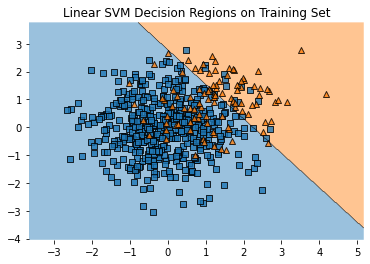

In [19]:
import matplotlib.pyplot as plt
import numpy as np
from generate_imbalance import get_data
from mlxtend.plotting import plot_decision_regions
from sklearn import svm

np.random.seed(0)
X_train, y_train = get_data(500, 100)
X_test, y_test = get_data(500, 500)

svm_fit = svm.SVC(C=1, kernel='linear').fit(X_train, y_train)
ax = plot_decision_regions(X=X_train, y=y_train, clf=svm_fit, legend=0)
ax.set(title='Linear SVM Decision Regions on Training Set')
plt.show() 

## (b) {-}

As shown in the below confusion matrix, the sensitivity (true positive rate) $158/(158+342) = 31.6\%$ is very low. 

The data points are from two bivariate normal distributions with mean $(0, 0)$ and $(1, 1)$, respectively, both having identity covariance matrices. 
The fair decision boundary should go through the midpoint of the two means, that is $(0.5, 0.5)$, but given the imbalanced data, there is a tendency for the decision boundary to move towards the top-left corner, as shown in the figure in (a). This is because when the decision boundary in the figure in (a) moves towards $(0.5, 0.5)$, while the prediction of some orange dots will be corrected, much more blue dots will be misclassified, adding penalty in SVM. 

When we use thus fitted model to predict the outcome of a balanced test set, given the tendency, one can expect a lot of orange dots will be misclassified. This explains the low true positive rate. 

In [2]:
from sklearn.metrics import confusion_matrix
from pandas import DataFrame

tn, fp, fn, tp = confusion_matrix(y_true=y_test, y_pred=svm_fit.predict(X_test)).ravel()

print('Misclassification Rate: ', (fp + fn)/(tn + fp + fn + tp))
print()

DataFrame([[tp, fp], [fn, tn]], columns=['True Y=1', 'True Y=0'], index=['Guess Y=1', 'Guess Y=0'])

Misclassification Rate:  0.358



,True Y=1,True Y=0
Guess Y=1,158,16
Guess Y=0,342,484


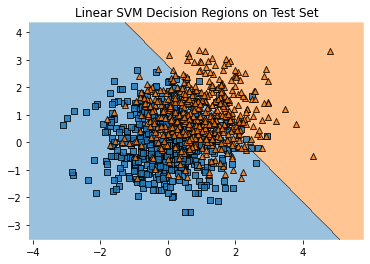

In [3]:
ax = plot_decision_regions(X=X_test, y=y_test, clf=svm_fit, legend=0)
ax.set(title='Linear SVM Decision Regions on Test Set')
plt.show()

## (c) {-}

```class_weight='balanced'``` adjusts the weights of the dots, moving the decision boundary back to the fair position. With this flag the fitted model has greatly improved true positive rate ($352/(352+148) = 70.4\%$) on the test data. The misclassfication rate is also improved. Below we report the misclassfication rate, a plot of decision boundary, and the confusion matrix.

Misclassification Rate:  0.257



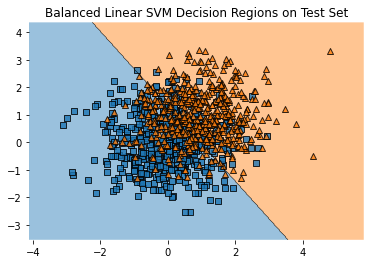

,True Y=1,True Y=0
Guess Y=1,352,109
Guess Y=0,148,391


In [6]:
svm_fit = svm.SVC(C=1, kernel='linear', class_weight='balanced').fit(X_train, y_train)


tn, fp, fn, tp = confusion_matrix(y_true=y_test, y_pred=svm_fit.predict(X_test)).ravel()

print('Misclassification Rate: ', (fp + fn)/(tn + fp + fn + tp))
print()

ax = plot_decision_regions(X=X_test, y=y_test, clf=svm_fit, legend=0)
ax.set(title='Balanced Linear SVM Decision Regions on Test Set')
plt.show()

DataFrame([[tp, fp], [fn, tn]], columns=['True Y=1', 'True Y=0'], index=['Guess Y=1', 'Guess Y=0'])

# 3. {-}

## (a) {-}

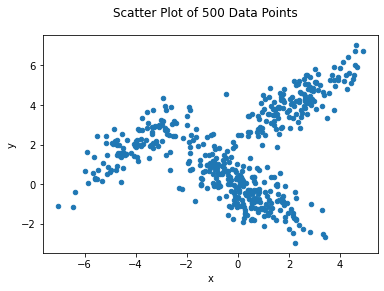

In [31]:
from pandas import DataFrame
from anomaly import get_data
import matplotlib.pyplot as plt
import numpy as np

np.random.seed(0)
X = get_data(500)
DataFrame(X, columns=['x', 'y']).plot(kind='scatter', x='x', y='y')
plt.suptitle('Scatter Plot of 500 Data Points')
plt.show()

## (b) {-}

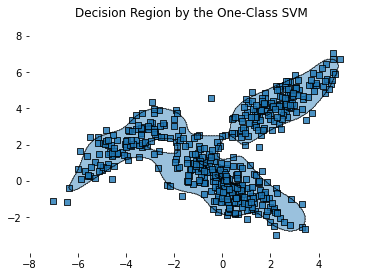

In [32]:
from mlxtend.plotting import plot_decision_regions
from sklearn import svm

one_class_svm_fit = svm.OneClassSVM(nu=0.1, kernel='rbf', gamma=0.5).fit(X)

plot_decision_regions(X=X, y=np.ones(500, dtype=int), clf=one_class_svm_fit, legend=0)
plt.suptitle('Decision Region by the One-Class SVM')
plt.show()

## (c) {-}

With smaller ```gamma``` is, the smoother the the decision boundary is. Large ```gamma``` seems to result in a model with higher variance and lower bias, while small ```gamma``` gives a model that has higher bias and lower variance. 

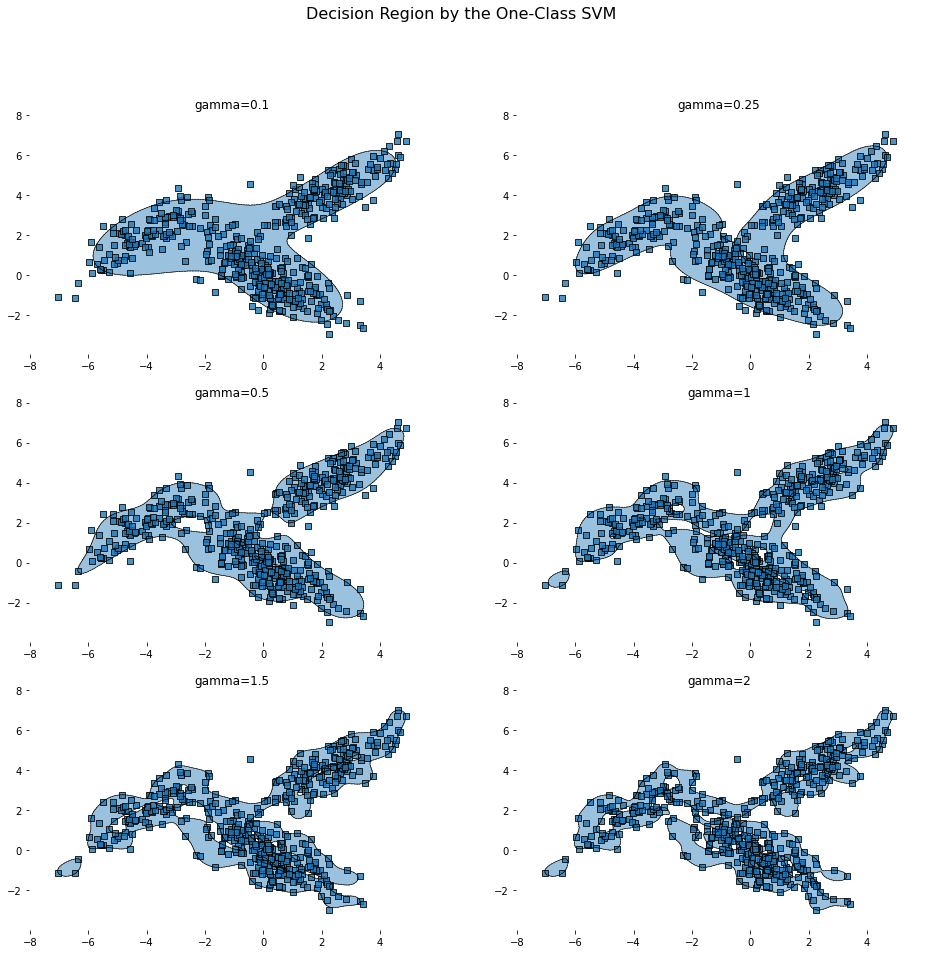

In [33]:
from mlxtend.plotting import plot_decision_regions
from sklearn import svm

fig, axs = plt.subplots(3, 2, figsize=(16, 15))

for gamma, ax in zip([0.1, 0.25, 0.5, 1, 1.5, 2], axs.ravel()):
    one_class_svm_fit = svm.OneClassSVM(nu=0.1, kernel='rbf', gamma=gamma).fit(X)
    plot_decision_regions(X=X, y=np.ones(500, dtype=int), clf=one_class_svm_fit, legend=0, ax=ax)
    ax.set(title='gamma=%s'%gamma)

plt.suptitle('Decision Region by the One-Class SVM', fontsize=16)
plt.show()

## (d) {-}

```nu``` is the sensitivity to outliers. More and more points will be identified as outliers as ```nu``` goes larger and larger. 

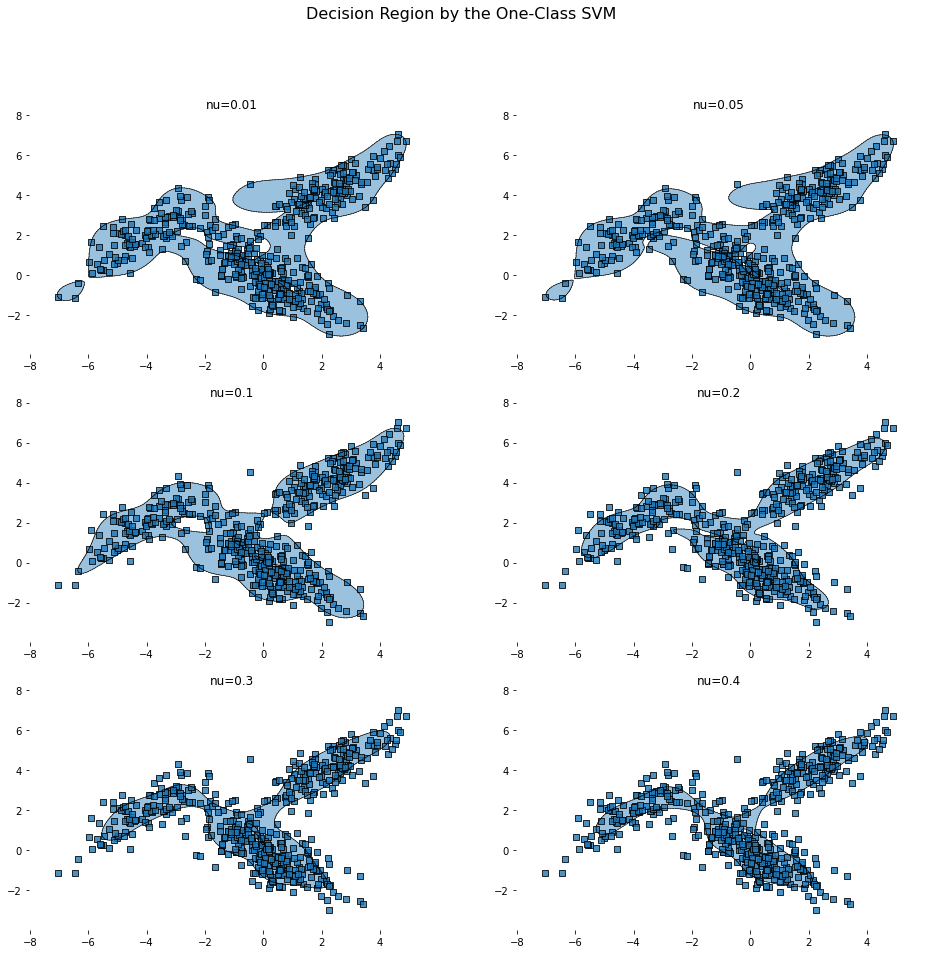

In [30]:
from mlxtend.plotting import plot_decision_regions
from sklearn import svm

fig, axs = plt.subplots(3, 2, figsize=(16, 15))

for nu, ax in zip([0.01, 0.05, 0.1, 0.2, 0.3, 0.4], axs.ravel()):
    one_class_svm_fit = svm.OneClassSVM(nu=nu, kernel='rbf', gamma=0.5).fit(X)
    plot_decision_regions(X=X, y=np.ones(500, dtype=int), clf=one_class_svm_fit, legend=0, ax=ax)
    ax.set(title='nu=%s'%nu)

plt.suptitle('Decision Region by the One-Class SVM', fontsize=16)
plt.show()

## (e) {-}

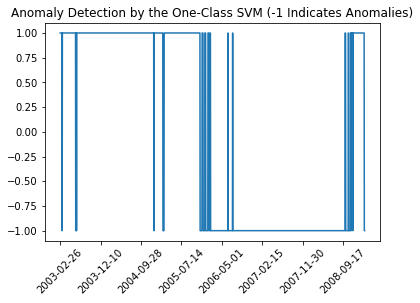

In [57]:
import pandas as pd
import matplotlib.pyplot as plt

data = pd.read_csv('DJIA_transformed.csv', header=None, index_col=0)
model = svm.OneClassSVM(nu=0.01, kernel='rbf', gamma=0.0000001).fit(data[:467])

data = data.assign(y=model.predict(data))
ax = data['y'].plot(rot=45)
ax.set(xlabel=None, title='Anomaly Detection by the One-Class SVM (-1 Indicates Anomalies)')
plt.show()

The data from early 2006 to September 2008 are identified as anomalous, when DJIA are above 11,000. Roughly speaking, the range of the DJIA index in the training period (2003-2004) is from 7,000 to 11,000. If a data point is not in this range, it will be identified as anomalous. The further away the DJIA is, the more anomalous the data point will be, according to the fitted SVM. 

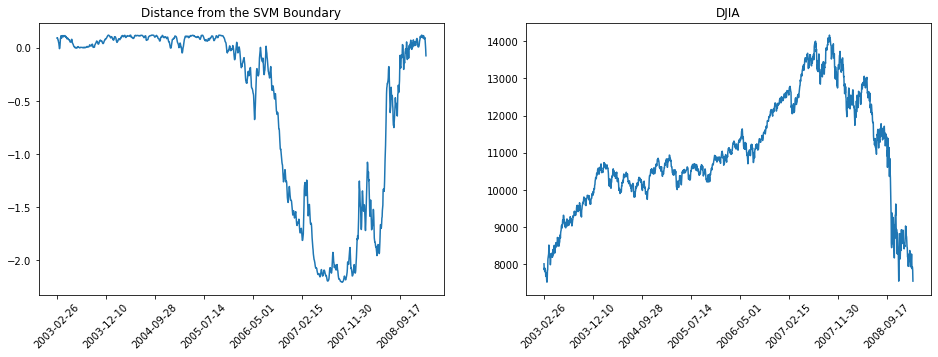

In [58]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 5))

data = data.assign(distance=model.decision_function(data.drop('y', axis='columns')))
data['distance'].plot(rot=45, ax=ax1)
ax1.set(xlabel=None, title='Distance from the SVM Boundary')

data[1].plot(rot=45, ax=ax2)
ax2.set(xlabel=None, title='DJIA')

plt.show()